In [1]:
import numpy as np
import torch
from mcspace.model import MCSPACE
from mcspace.trainer import train_model
from mcspace.data_utils import get_data, get_mouse_diet_perturbations_dataset
from mcspace.utils import get_device, pickle_load, pickle_save,\
    estimate_process_variance, MODEL_FILE, DATA_FILE, \
    get_mcspace_cooccur_prob, get_sig_perturbation_diff_subset, \
    get_posterior_summary_data, get_pert_otu_sub, get_min_loss_path, apply_taxonomy_threshold, \
    get_summary_results
from pathlib import Path
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
import mcspace.visualization as vis
from mcspace.dataset import DataSet
import pandas as pd

import ete3
from Bio import SeqIO, Phylo

import mcspace.vis_tools as vis
import matplotlib.colors as mcolors
import networkx as nx

In [2]:
# change font
mpl.rcParams['font.sans-serif'] = "Arial"
mpl.rcParams['font.family'] = "sans-serif"

# Paths

In [3]:
rootpath = Path("../../")
basepath = Path("./")

In [4]:
runpath = rootpath / "paper" / "mouse_runs" / "runs"

In [5]:
treepath = rootpath / "data" / "mouse_experiments" / "output" # *** rename this
treefile = "newick_tree_query_reads.nhx"

In [6]:
outpath = basepath / "figs_mouse_results"
outpath.mkdir(exist_ok=True, parents=True)

# Load best model

In [7]:
respath = get_min_loss_path(runpath, np.arange(10))

model = torch.load(respath / MODEL_FILE)
data = pickle_load(respath / DATA_FILE)

taxonomy = pickle_load(respath / "taxonomy.pkl")

times = list(data['count_data'].keys())
subjects = list(data['count_data'][10].keys())
num_otus = data['count_data'][times[0]][subjects[0]].shape[1]
num_times = len(times)
num_subjects = len(subjects)

0
1
2
3
4
5
6
7
8
9
4


In [8]:
taxonomy = apply_taxonomy_threshold(taxonomy)

# do beforehand..
name_updates = {'Otu10': {'Species': 'Faecalibaculum rodentium'},
'Otu17': {'Genus': 'Roseburia'},
'Otu6': {'Species': 'Eubacterium coprostanoligenes'},
'Otu20': {'Species': 'Muribaculum gordoncarteri'},
'Otu15': {'Genus': 'Eisenbergiella'},
'Otu43': {'Family': 'Lachnospiraceae'}}

taxonomy['Species'] = 'na'
for oidx in name_updates.keys():
    replace = name_updates[oidx]
    key = list(replace.keys())[0]
    newname = replace[key]
    taxonomy.loc[oidx,key] = newname

# Get summary results

In [9]:
thetadf, betadf, pertsdf = get_posterior_summary_data(model, data, taxonomy, times, subjects)

# Render association changes

## methods (move to vis utils...)

In [10]:
# def get key focus taxa...
taxa_foci = ['Otu2', 'Otu6']

## get associated assemblages and taxa...

In [11]:
otu_threshold = 0.05


In [12]:
def get_assemblages_containing_taxon(thetadf, oidx, otu_threshold=0.05):
    thetasub = thetadf.loc[thetadf.index.get_level_values('Otu') == oidx,:]
    assemblages = thetasub.columns[(thetasub > otu_threshold).any(axis=0)]
    return assemblages

In [13]:
assemblages = get_assemblages_containing_taxon(thetadf, 'Otu2')

In [14]:
def get_taxa_in_assemblages(thetadf, assemblages, otu_threshold=0.05):
    otus = thetadf.index[(thetadf.loc[:,assemblages]>otu_threshold).any(axis=1)].get_level_values('Otu')
    return otus

In [15]:
otus = get_taxa_in_assemblages(thetadf, assemblages)

In [16]:
otus

Index(['Otu15', 'Otu12', 'Otu67', 'Otu1', 'Otu7', 'Otu17', 'Otu41', 'Otu38',
       'Otu20', 'Otu10', 'Otu2', 'Otu29', 'Otu6'],
      dtype='object', name='Otu')

In [17]:
betadf

Time Subject Assemblage     Value  log10Value
0       10    JX07         A1  0.000394   -3.404146
1       10    JX07         A2  0.000474   -3.324155
2       10    JX07         A3  0.000331   -3.479800
3       10    JX07         A4  0.001311   -2.882305
4       10    JX07         A5  0.000457   -3.339711
...    ...     ...        ...       ...         ...
1591    76    JX10        A72  0.029808   -1.525661
1592    76    JX10        A73  0.059759   -1.223600
1593    76    JX10        A74  0.006094   -2.215118
1594    76    JX10        A75  0.000333   -3.477357
1595    76    JX10        A76  0.000058   -4.233602

[1596 rows x 5 columns]

In [18]:
def get_subj_averaged_assemblage_proportions(betadf):
    subjave = betadf.loc[:,['Time','Assemblage','Value']].groupby(by=['Time','Assemblage']).mean()
    subjave.reset_index(inplace=True)
    betamat = subjave.pivot(index='Time', columns='Assemblage', values='Value')
    return betamat

In [19]:
avebeta = get_subj_averaged_assemblage_proportions(betadf)

In [20]:
# using subject averaged beta... (check if this ok; might actually want to change slightly....)
# get for each time point; later average over standard times...
def get_edge_weights(thetadf, avebeta, otu_focus, otus_assoc):
    times = avebeta.index
    assemblages = thetadf.columns
    thetasimp = thetadf.reset_index()[['Otu'] + list(assemblages)].set_index('Otu')
    
    theta_self = thetasimp.loc[otu_focus,:].values # 1xK
    theta_assoc = thetasimp.loc[otus_assoc,:].values # OxK
    betavals = avebeta.loc[:,assemblages].values # ntime x K
    
    numerator = np.sum(betavals[:,None,:]*theta_assoc*theta_self, axis=-1)
    denominator = np.sum(betavals[:,None,:]*theta_self, axis=-1)
    
    edgevals = numerator/denominator
    df = pd.DataFrame(edgevals, index=times, columns=otus_assoc)
    return df.T

In [21]:
edge_weights = get_edge_weights(thetadf, avebeta, 'Otu2', otus)

In [22]:
edge_weights

Time         10        18        35        43        57        65        76
Otu                                                                        
Otu15  0.000905  0.002534  0.000519  0.000563  0.002378  0.004558  0.002984
Otu12  0.003600  0.004482  0.003625  0.000543  0.008570  0.004756  0.006065
Otu67  0.002259  0.020988  0.003364  0.000158  0.016967  0.000721  0.065444
Otu1   0.027919  0.005964  0.051851  0.000932  0.055912  0.000971  0.030901
Otu7   0.004970  0.013746  0.002863  0.001980  0.012943  0.021404  0.014071
Otu17  0.001687  0.013497  0.001597  0.000320  0.006256  0.006726  0.014799
Otu41  0.003048  0.025054  0.006777  0.000542  0.020172  0.002207  0.036976
Otu38  0.023119  0.003973  0.006840  0.000387  0.015883  0.008746  0.001448
Otu20  0.009181  0.002370  0.003901  0.000545  0.031337  0.009483  0.039529
Otu10  0.003453  0.006845  0.001295  0.001803  0.026431  0.018160  0.005493
Otu2   0.809278  0.783204  0.813951  0.975116  0.442178  0.862574  0.374966
Otu29  0.009814  0.028107  0.001209  0.000115  0.006530  0.008604  0.010102
Otu6   0.012487  0.015208  0.010947  0.001921  0.028015  0.022254  0.015216

In [42]:
def get_relative_abundances(data, times, subjects, taxonomy, multi_index=False):
    reads = data['count_data']
    ntime = len(times)
    nsubj = len(subjects)
    notus = reads[times[0]][subjects[0]].shape[1]

    relabuns = np.zeros((notus, ntime, nsubj)) # also make into dataframe
    for i,t in enumerate(times):
        for j,s in enumerate(subjects):
            counts = reads[t][s].cpu().detach().clone().numpy()
            pra = counts/counts.sum(axis=1,keepdims=True)
            ras = np.mean(pra, axis=0)
            relabuns[:,i,j] = ras

    if multi_index is True:
        index = pd.MultiIndex.from_frame(taxonomy.reset_index())
    else:
        index = taxonomy.index 
    radf = pd.DataFrame(relabuns.mean(axis=2), index=index, columns=times)
    return radf

In [43]:
radf = get_relative_abundances(data, times, subjects, taxonomy)

In [44]:
radf.head()

10        18        35        43        57        65  \
Otu                                                                     
Otu19  8.851155e-03  0.000547  0.003100  0.000707  0.007016  0.007629   
Otu37  6.800378e-07  0.003632  0.000052  0.000020  0.009004  0.004492   
Otu24  1.674976e-03  0.000347  0.010295  0.002249  0.017545  0.002000   
Otu15  3.286075e-03  0.017412  0.002091  0.060776  0.004819  0.012782   
Otu22  4.171356e-02  0.015233  0.006992  0.005668  0.001008  0.005060   

             76  
Otu              
Otu19  0.039296  
Otu37  0.029349  
Otu24  0.045857  
Otu15  0.015945  
Otu22  0.001827

In [38]:
# average standard diet time points; rename diets

In [58]:
# dict of diets and times
diet_times = {'STD': [10,35,57,76],
'HF': [18],
'HFHF': [43],
'LP': [65]}

In [59]:
def average_diet_times(df, diet_times):
    df2 = df.copy()
    diets_keep = list(diet_times.keys())
    for k in diets_keep:
        df2[k] = df.loc[:,diet_times[k]].mean(axis=1)
    df2 = df2[diets_keep]
    return df2

In [66]:
# match same index as edge weights dataframe
ratemp = radf.loc[edge_weights.index,:]

In [67]:
node_weights = average_diet_times(ratemp, diet_times)

In [68]:
node_weights

STD        HF      HFHF        LP
Otu                                          
Otu15  0.006535  0.017412  0.060776  0.012782
Otu12  0.008222  0.025964  0.018783  0.021430
Otu67  0.002308  0.014471  0.001184  0.001008
Otu1   0.240700  0.110752  0.202902  0.012623
Otu7   0.006949  0.155743  0.000924  0.089202
Otu17  0.001178  0.042695  0.003755  0.037520
Otu41  0.003254  0.039001  0.004629  0.006763
Otu38  0.003037  0.002256  0.000416  0.019459
Otu20  0.005345  0.002962  0.005396  0.044075
Otu10  0.004517  0.004152  0.029402  0.073203
Otu2   0.013414  0.058312  0.406669  0.229467
Otu29  0.001560  0.041326  0.000620  0.040834
Otu6   0.036487  0.070301  0.005223  0.133280

In [62]:
assoc_edge_weights = average_diet_times(edge_weights, diet_times)

In [63]:
assoc_edge_weights

Time        STD        HF      HFHF        LP
Otu                                          
Otu15  0.001697  0.002534  0.000563  0.004558
Otu12  0.005465  0.004482  0.000543  0.004756
Otu67  0.022009  0.020988  0.000158  0.000721
Otu1   0.041646  0.005964  0.000932  0.000971
Otu7   0.008712  0.013746  0.001980  0.021404
Otu17  0.006085  0.013497  0.000320  0.006726
Otu41  0.016743  0.025054  0.000542  0.002207
Otu38  0.011823  0.003973  0.000387  0.008746
Otu20  0.020987  0.002370  0.000545  0.009483
Otu10  0.009168  0.006845  0.001803  0.018160
Otu2   0.610093  0.783204  0.975116  0.862574
Otu29  0.006914  0.028107  0.000115  0.008604
Otu6   0.016666  0.015208  0.001921  0.022254

In [71]:
edge_weights = assoc_edge_weights # rename in final pipeline

In [69]:
# plot association changes (axs, edge_weights, node_weights, otu_focus; optional scaling args...) # return axes

In [98]:
def plot_association_changes(axs, edge_weights, node_weights, otu_focus, node_colors=None, edge_scale=20, node_scale=2000):
    taxa = edge_weights.index
    diets = edge_weights.columns

    # make graph
    graph = nx.Graph()
    # add nodes and edges with default weights
    for oidx in taxa:
        if oidx != otu_focus:
            graph.add_edge(oidx, otu_focus, weight=1)
        graph.nodes[oidx]['weight'] = 500

    # get node positions
    pos = nx.spring_layout(graph)

    for i,diet in enumerate(diets):
        # update edge weights
        for oidx in taxa:
            if oidx != otu_focus:
                graph[oidx][otu_focus]['weight'] = edge_scale*edge_weights.loc[oidx,diet]
            # update node sizes
            graph.nodes[oidx]['weight']=node_scale*node_weights.loc[oidx,diet]

        # get node colors
        color_map = []
        for node in graph:
            if node_colors is not None:
                color_map.append(node_colors[node])
            else:
                color_map.append('tab:blue')

        # draw network
        ew = list(nx.get_edge_attributes(graph,'weight').values())
        nw = list(nx.get_node_attributes(graph,'weight').values())
        nx.draw_networkx(graph, pos=pos, ax=axs[i], width=ew, node_size=nw, 
                         node_color=color_map, with_labels=False)
        
        # annotate nodes
        delta_y = 0.1
        for k in pos.keys():
            x = pos[k][0]
            y = pos[k][1]
            axs[i].text(x,y+delta_y,s=f'{k}', horizontalalignment='center')
    return axs

In [102]:
ncolors = {}
for oidx in edge_weights.index:
    ncolors[oidx] = 'tab:red'

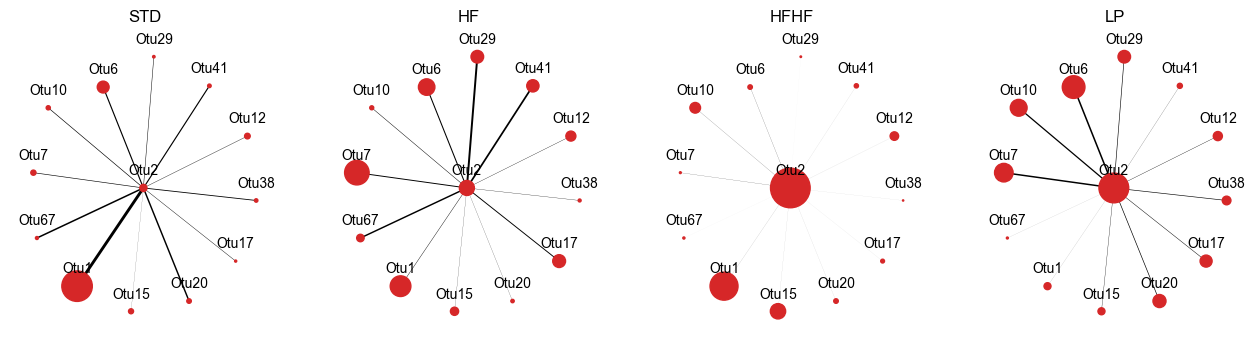

In [103]:
fig, axs = plt.subplots(figsize=(16,4), ncols=4)
axs=plot_association_changes(axs, edge_weights, node_weights, 'Otu2', node_colors=ncolors, edge_scale=50)
diets = edge_weights.columns
for ax, diet in zip(axs, diets):
    ax=vis.remove_border(ax)
    ax.set_title(diet)

In [78]:
axs

array([None, None, None, None], dtype=object)

In [75]:
# to do; color nodes by family; reposition text labels... (use pos to create text labels);
# ... move text labels to center and remove 'otu'; decrease alpha; or move on 'circle'... (project out a 'delta_r')
# node positions may vary - > guarentee position?, or set seed?
# option to also add custom annotation (name the actual taxa... instead of otu#)
# also option to 

In [76]:
pos

{'Otu15': array([-0.96951089,  0.10802707]),
 'Otu2': array([-0.00063095,  0.00189357]),
 'Otu12': array([0.75080044, 0.32332968]),
 'Otu67': array([ 1.        , -0.09156674]),
 'Otu1': array([0.12254092, 0.93536305]),
 'Otu7': array([-0.59501205, -0.80686577]),
 'Otu17': array([0.62154347, 0.78731237]),
 'Otu41': array([-0.37065136,  0.87459693]),
 'Otu38': array([-0.10426285, -0.89191718]),
 'Otu20': array([-0.8301353 , -0.36494869]),
 'Otu10': array([ 0.38902066, -0.89297751]),
 'Otu29': array([ 0.74840673, -0.54642909]),
 'Otu6': array([-0.76210883,  0.56418231])}

In [89]:
pos['Otu15'][1]

0.10802707106571952

In [96]:
graph

In [97]:
for node in graph:
    print(node)

Otu15
Otu2
Otu12
Otu67
Otu1
Otu7
Otu17
Otu41
Otu38
Otu20
Otu10
Otu29
Otu6
